In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import gym
import collections
import math

In [2]:
env_name = 'MountainCar-v0'
env = gym.make(env_name)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
NUM_STATES = env.env.observation_space.shape[0]
NUM_ACTIONS = env.env.action_space.n

In [4]:
NUM_BATCHES = 32
GAMMA = 0.99
EPSILON = 1.0

# Create model using Keras
***

In [5]:
def create_model(input_shape, num_actions):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(input_shape=input_shape,
                           units=12,
                           activation=tf.nn.relu)
    )
    model.add(
        keras.layers.Dense(units=12,
                           activation=tf.nn.relu)
    )
    model.add(
        keras.layers.Dense(units=num_actions)
    )
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.mean_squared_error,
        metrics=['accuracy']
    )
    
    return model

Make a test class to see whether model is created properly:

In [6]:
testModel = create_model(
    input_shape=(2,),
    num_actions=2
)
testModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                36        
_________________________________________________________________
dense_1 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 26        
Total params: 218
Trainable params: 218
Non-trainable params: 0
_________________________________________________________________


# Same Memory Class...
***

In [7]:
class Memory:
    def __init__(self, maxMemory):
        self._samples = collections.deque(maxlen = maxMemory)
        
    def add_sample(self, sample):
        self._samples.append(sample)
        
    def sample(self, nSamples):
        deqLen = len(self._samples)
        
        ### DEBUG ###
        #print ("dequelen: {}".format(deqLen))
        #print ("nSamples: {}".format(nSamples))
        #print ("High: {}".format(high))
        
        
        size = np.min([nSamples, deqLen])       # Lower of either nSamples or deqLen
        x = np.random.choice(a = deqLen,        # Randomly select indices from array
                             size = size,           # Random sample size  
                             replace = False)       # Replacement set to False
        
        return [self._samples[i] for i in x]    # Return list of randomly chosen indices
        

# Create Custom GameRunner class
***

In [8]:
class GameRunner:
    
    def __init__(self, model, env, memory, epsilon, gamma, render=False):
        self.env = env
        self.model = model
        self.memory = memory
        self.render = render
        
        self.epsilon = epsilon
        self.gamma = gamma
        
        self.steps = 0
        self.reward_store = []
        self.max_x_store = []
        
    def choose_action(self, state):
        # print ('GameRunner.choose_action() called')
        random = np.random.random()
        # print ('\t random: {}'.format(random))
        if random < self.epsilon: 
            # print ('\t\t random less than epsilon, random action chosen')
            return np.random.randint(0, NUM_ACTIONS)
        else: 
            '''
            print ('\t random greater than epsilon, action predicted')
            print ('\t\t state: {}'.format(state))
            print ('\t\t state.shape: {}'.format(state.shape))
            '''
            return np.argmax(
                self.model.predict(x=state.reshape(1,-1), batch_size=1, verbose=0, steps=None)
            )
        
    def replay(self):
        # Create batch of randomly sampled pairs from memory
        batch = self.memory.sample(NUM_BATCHES)
        # Extract states from batch
        states = np.array([x[0] for x in batch])
        # Extract next states from batch
        next_states = np.array([np.zeros(NUM_STATES) if x[3] is None else x[3] for x in batch])
        
        # Calculate Q(s,a) given states
        qsa  = self.model.predict_on_batch(states)
        # Calculate Q(s',a') given next states
        qsad = self.model.predict_on_batch(next_states)
        
        # Empty arrays holding states and corresponding actions
        x = np.zeros((len(batch), NUM_STATES))
        y = np.zeros((len(batch), NUM_ACTIONS))
        
        for i, b in enumerate(batch):
            state, action, reward, next_state = b[0], b[1], b[2], b[3]
            # This is the Q(s,a) for ith sample
            current_q = qsa[i]                                   
            # If next state was None, simply reward
            if next_state is None: current_q[action] = reward
            # Update Q(s,a) for specified action using max value of Q(s',a')
            else: current_q[action] = reward + self.gamma*np.amax(qsad[i])
            
            x[i] = state
            y[i] = current_q
        
        # Batch train
        self.model.train_on_batch(x, y)
        
        
    def run(self):
        ### DEBUG ###
        # print ('GameRunner.run() has been called')
        
        state = self.env.reset()   # Reset the environment
        # print ('\t (state, shape): ({},{})'.format(state, state.shape))
        
        total_reward = 0           # Start @ 0
        max_x = -100               # starting value
        while True:
            # Render the game if wanted
            if self.render: self.env.render()
            # Choose an action (either random or greedy)
            action = self.choose_action(state)
            # take a step forward in the environment
            next_state, reward, done, info = self.env.step(action)
            
            '''
            print ('Step # {}'.format(self.steps))
            print ('\tstate: {}'.format(state))
            print ('\tinitial reward: {}'.format(reward))
            '''
            ### Custom increase to reward function ###
            if next_state[0] >= 0.1: reward += 10
            elif next_state[0] >= 0.25: reward += 20
            elif next_state[0] >= 0.5: reward += 100
            # reward += state[0]   # increase reward based on position
            # print ('\tpost reward: {}'.format(reward))
            
            if next_state[0] > max_x: max_x = next_state[0]    # increase max_x if appropriate
                
                
            if done: next_state = None
                
            self.memory.add_sample((state, action, reward, next_state))
            self.replay()
            
            
            ## Exponentially decay the epsilon value
            DECAY = 0.000001
            MIN_EPSILON = 0.01
            self.epsilon = MIN_EPSILON + (self.epsilon - MIN_EPSILON) * math.exp(-DECAY * self.steps)
        
            # Make the next_state the new current state
            state = next_state
            
            # Increase total reward
            total_reward += reward
            # print ('\ttotal reward: {}'.format(total_reward))
            
            # Increase step counter
            self.steps += 1
            
            # If game is done, break loop:
            if done:
                self.reward_store.append(total_reward)
                self.max_x_store.append(max_x)
                break
        if self.steps % 1000 == 0:    
            print ("Step {}, Total reward: {}, Eps: {}".format(self.steps, total_reward, self.epsilon))
    

# TEST IT OUT!!
***

In [9]:
model = create_model(
    input_shape=(NUM_STATES,),
    num_actions=NUM_ACTIONS
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 12)                36        
_________________________________________________________________
dense_4 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 39        
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [10]:
mem = Memory(50000)

In [11]:
total_reward = []
max_x_score = []

In [12]:
gr = GameRunner(
    model=model,
    env=env,
    memory=mem,
    epsilon=EPSILON,
    gamma=GAMMA,
    render=False
)

In [13]:
num_episodes = 300

In [14]:
count = 0

In [15]:
while count < num_episodes:
    if count % 25 == 0:
        print ('Episode {} of {}'.format(count+1, num_episodes))
    gr.run()
    count += 1

Episode 1 of 300
Step 1000, Total reward: -200.0, Eps: 0.6107656608627463
Step 2000, Total reward: -200.0, Eps: 0.14411597934795164
Step 3000, Total reward: -200.0, Eps: 0.021014415811552424
Step 4000, Total reward: -200.0, Eps: 0.01033277288228576
Step 5000, Total reward: -200.0, Eps: 0.010003698621645896
Episode 26 of 300
Step 6000, Total reward: -200.0, Eps: 0.01000001512298091
Step 7000, Total reward: -200.0, Eps: 0.010000000022747845
Step 8000, Total reward: -200.0, Eps: 0.01000000000001258
Step 9000, Total reward: -200.0, Eps: 0.010000000000000096
Step 10000, Total reward: -200.0, Eps: 0.010000000000000087
Episode 51 of 300
Step 11000, Total reward: -200.0, Eps: 0.010000000000000078
Step 12000, Total reward: -200.0, Eps: 0.010000000000000071
Step 13000, Total reward: -200.0, Eps: 0.010000000000000066
Step 14000, Total reward: -200.0, Eps: 0.010000000000000061
Step 15000, Total reward: -200.0, Eps: 0.010000000000000057
Episode 76 of 300
Step 16000, Total reward: -170.0, Eps: 0.010

In [16]:
total_reward = gr.reward_store
max_x_score = gr.max_x_store

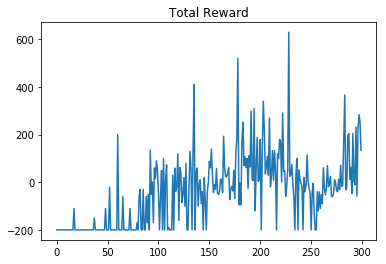

<function matplotlib.pyplot.show(*args, **kw)>

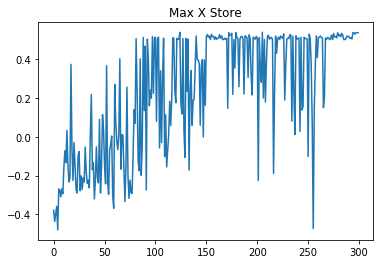

In [17]:
plt.plot(total_reward)
plt.title('Total Reward')
plt.show()
    
plt.close("all")
plt.plot(max_x_score)
plt.title('Max X Store')
plt.show